# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions" data-toc-modified-id="Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quality Control on the hypoxia response and the hif-1 direct target predictions</a></div><div class="lev1 toc-item"><a href="#TEA-on-hypoxia-response" data-toc-modified-id="TEA-on-hypoxia-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TEA on hypoxia response</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import gvars
import genpy

# stats
from scipy import stats as sts

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}

sns.set(style='dark', context='notebook', font='sans-serif')

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [3]:
# import the code <--> genotype mapping and other useful variables
genvar = gvars.genvars()

In [4]:
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

In [5]:
hypoxia_direct_targets = pd.read_csv('../output/hypoxia_targets_candidates.csv')

In [7]:
hypoxia_response = pd.read_csv('../output/hypoxia_response.csv')

In [9]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [10]:
frames = []
for key, df in thomas.beta.items():
    df['code'] = key
    df['genotype'] = genvar.fancy_mapping[key]
    frames += [df]

tidy = pd.concat(frames)

In [24]:
x = ['WBGene00012324',
     'WBGene00001178',
     'WBGene00003647',
     'WBGene00002248'
    ]

x_sort = {'WBGene00012324': 1,
          'WBGene00001178': 2,
          'WBGene00003647': 3,
          'WBGene00002248': 4
         }

plot_df = tidy[(tidy.ens_gene.isin(x)) & (tidy.code != 'g')].copy()

# # Pick the hif-1 isoform that is present in all genotypes:
# plot_df = plot_df[plot_df.target_id != 'F38A6.3d']
plot_df['order'] = plot_df.ens_gene.map(x_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

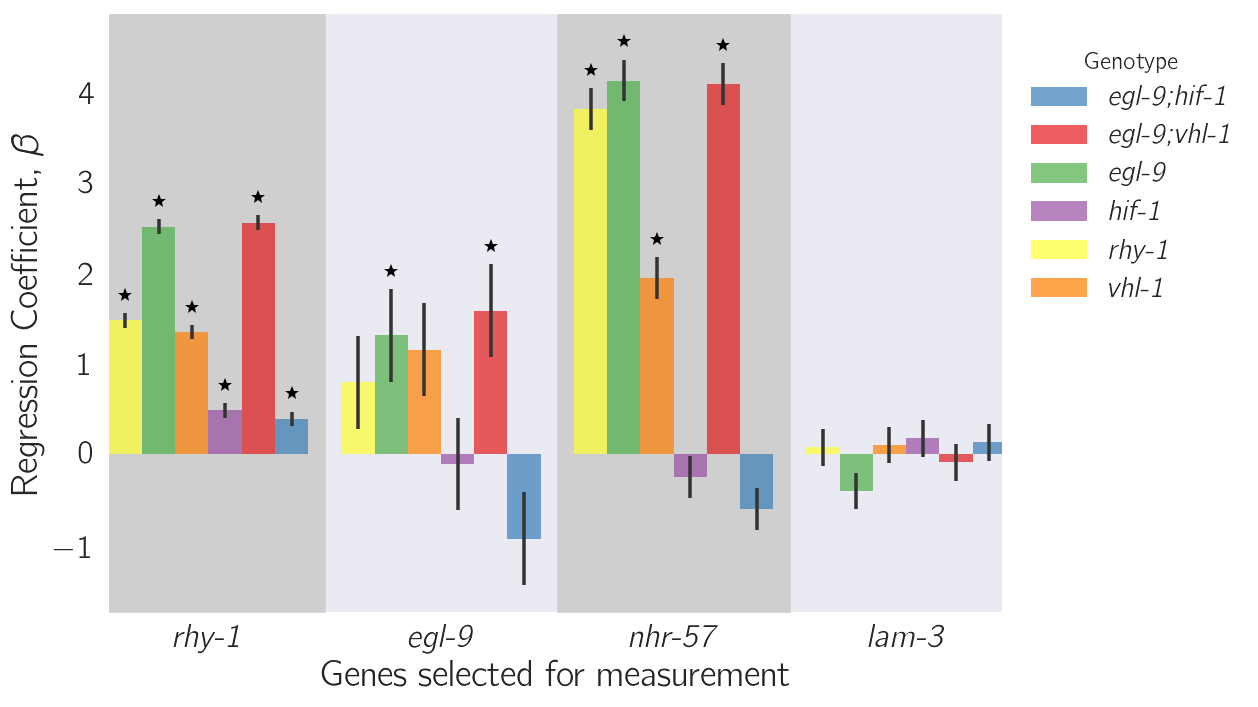

In [25]:
genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color, clustering='genotype', plotting_group='ext_gene', rotation=0)
plt.xlabel(r'Genes selected for measurement', fontsize=18)
save = '../output/hif1_qualitycontrol.svg'
plt.savefig(save, bbox_inches='tight')

# Quality Control on the hypoxia response and the hif-1 direct target predictions

In [15]:
def test_significance(df, gold=hypoxia_gold):
    ind = df.ens_gene.isin(hypoxia_gold.WBIDS)
    found = df[ind].ens_gene.unique()
    sig = len(df)  # number of genes that we picked
    ntotal = len(thomas.beta['a'])  # total genes measured
    pval = sts.hypergeom.sf(len(found),
                            ntotal,
                            len(hypoxia_gold), sig)    

    if pval < 10**-3:
        print('This result is statistically significant' +\
              ' with a p-value of {0:.2g} using a hypergeometric test.'.format(pval) +\
              'You found {0} gold standard genes!'.format(len(found)))
    else:
        print(pval)

In [16]:
test_significance(hypoxia_response)

This result is statistically significant with a p-value of 2.7e-06 using a hypergeometric test.You found 5 gold standard genes!


In [17]:
test_significance(hypoxia_direct_targets)

This result is statistically significant with a p-value of 3.8e-08 using a hypergeometric test.You found 5 gold standard genes!


# TEA on hypoxia response

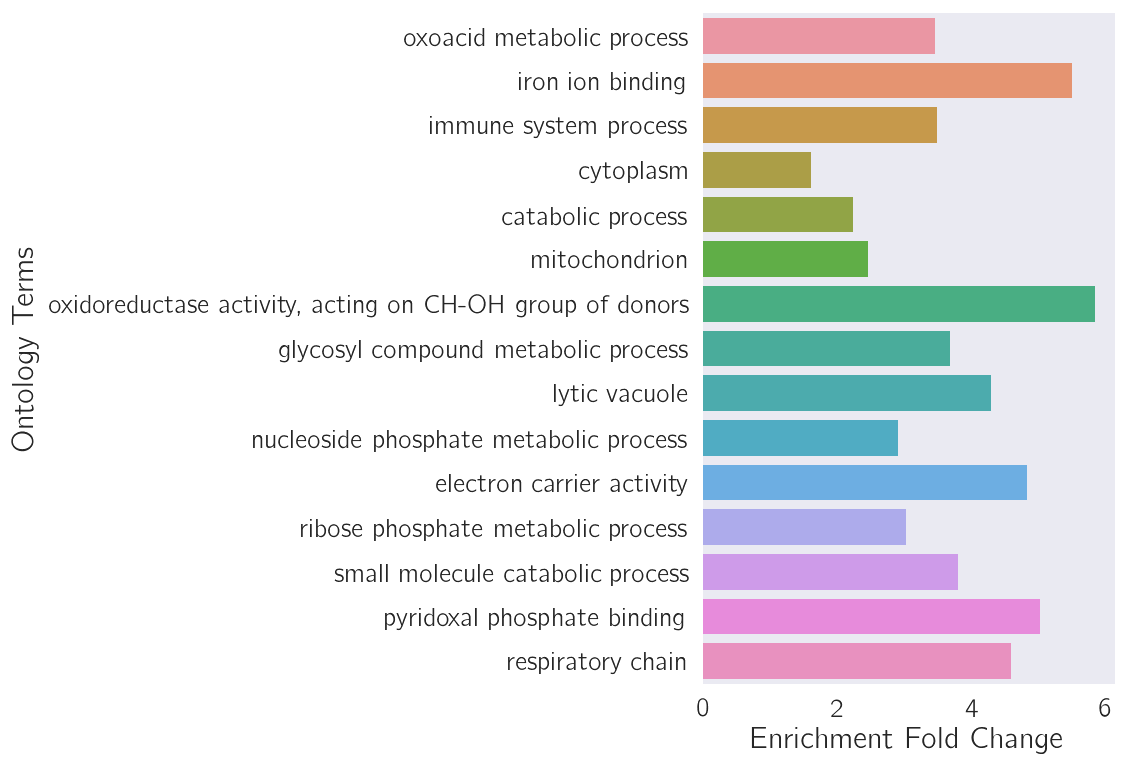

In [18]:
_ = tea.enrichment_analysis(hypoxia_response.ens_gene.unique(), go_df, show=False)
ax = tea.plot_enrichment_results(_, analysis='go')
plt.savefig('../output/hypoxia_response_gea.svg')

In [23]:
_ = tea.enrichment_analysis(hypoxia_response.ens_gene.unique(), phenotype_df, show=False)
_

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
16,pleiotropic defects severe early emb WBPhenoty...,2.031332,9,4.430590,0.000040,0.007124
67,oxygen response variant WBPhenotype:0000464,1.208727,7,5.791218,0.000028,0.007124


In [22]:
_ = tea.enrichment_analysis(hypoxia_response.ens_gene.unique(), tissue_df, show=False)
_

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
94,cephalic sheath cell WBbt:0008406,4.401627,13,2.953454,0.000167,0.045473
